__Autoencoders__  




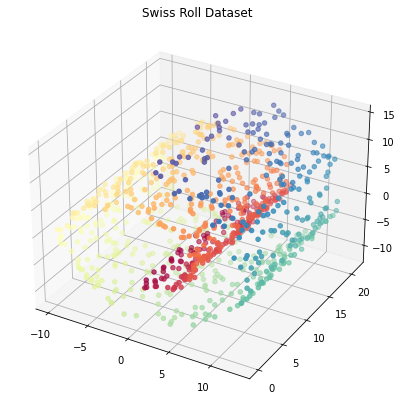

In [11]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate the data
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Plot the 3D Swiss Roll
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
plt.title("Swiss Roll Dataset")
plt.show()

**Simple AutoEncoder**

Epoch 1/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1920
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0574
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0283
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0252
Epoch 9/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 10/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 11/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 12/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 13/50
24/24 [==============================

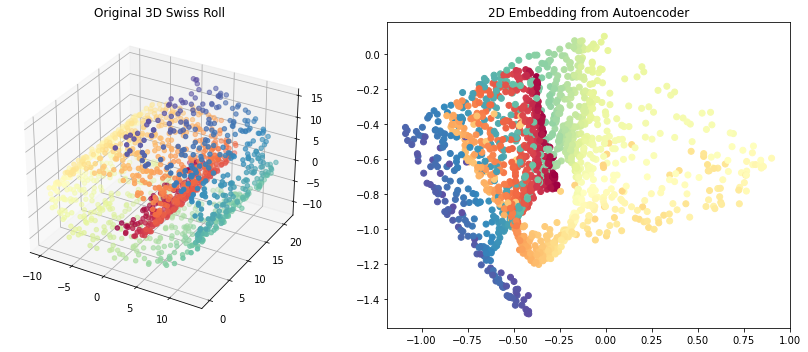

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Step 1: Generate Swiss Roll data
X, t = make_swiss_roll(n_samples=1500, noise=0.2)

# Step 2: Normalize data to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Build the autoencoder
input_layer = Input(shape=(3,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(2)(encoded)  # 2D embedding

decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(3)(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bottleneck)

autoencoder.compile(optimizer='adam', loss='mse')

# Step 4: Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, verbose=1)

# Step 5: Get 2D encoded representation
X_encoded = encoder.predict(X_scaled)

# Step 6: Plot results
fig = plt.figure(figsize=(12, 5))

# Original 3D Swiss Roll
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax1.set_title("Original 3D Swiss Roll")

# Encoded 2D representation
ax2 = fig.add_subplot(122)
ax2.scatter(X_encoded[:, 0], X_encoded[:, 1], c=t, cmap=plt.cm.Spectral)
ax2.set_title("2D Embedding from Autoencoder")

plt.tight_layout()
plt.show()

**AutoEncoder With Contrastive Learning Through Siamese Network**

Epoch 1/20
782/782 [==============================] - 2s 2ms/step - loss: 0.1006
Epoch 2/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0593
Epoch 3/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0428
Epoch 4/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0365
Epoch 5/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0338
Epoch 6/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0326
Epoch 7/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0320
Epoch 8/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0317
Epoch 9/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0315
Epoch 10/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0313
Epoch 11/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0313
Epoch 12/20
782/782 [==============================] - 2s 2ms/step - loss: 0.0312
Epoch 13/20
782/782 [====

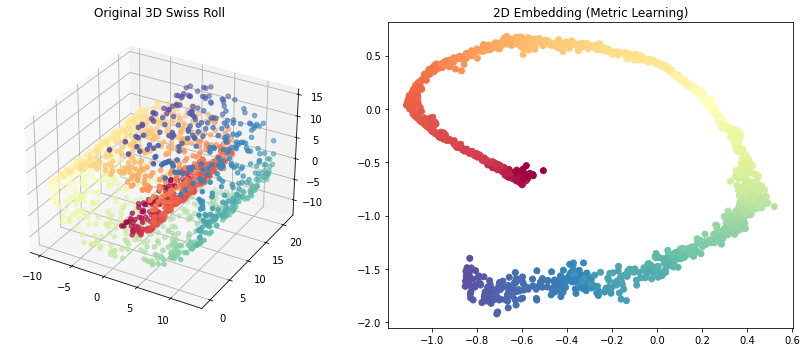

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
import tensorflow.keras.backend as K

# Step 1: Generate and normalize Swiss Roll data
X, t = make_swiss_roll(n_samples=1500, noise=0.2)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Create pairs of similar/dissimilar points based on intrinsic distance
def create_pairs(X, t, threshold=1.0, max_pairs=100000):
    pairs = []
    labels = []
    n = len(X)
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.abs(t[i] - t[j])
            label = 1 if dist < threshold else 0
            pairs.append([X[i], X[j]])
            labels.append(label)
            if len(pairs) >= max_pairs:
                return np.array(pairs), np.array(labels)
    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs(X_scaled, t)

# Step 3: Define encoder model
def build_encoder():
    inp = Input(shape=(3,))
    x = Dense(64, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    out = Dense(2)(x)  # 2D embedding
    return Model(inp, out)

encoder = build_encoder()

# Step 4: Define contrastive loss
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)  # 👈 Cast to float32
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Step 5: Siamese network for training
input_a = Input(shape=(3,))
input_b = Input(shape=(3,))
embedding_a = encoder(input_a)
embedding_b = encoder(input_b)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance)([embedding_a, embedding_b])
siamese_net = Model(inputs=[input_a, input_b], outputs=distance)
siamese_net.compile(loss=contrastive_loss, optimizer='adam')

# Step 6: Train the model
siamese_net.fit([pairs[:, 0], pairs[:, 1]], labels, batch_size=128, epochs=20)

# Step 7: Visualize the learned 2D embedding
X_encoded = encoder.predict(X_scaled)

fig = plt.figure(figsize=(12, 5))

# Original 3D Swiss Roll
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax1.set_title("Original 3D Swiss Roll")

# 2D embedding from encoder
ax2 = fig.add_subplot(122)
ax2.scatter(X_encoded[:, 0], X_encoded[:, 1], c=t, cmap=plt.cm.Spectral)
ax2.set_title("2D Embedding (Metric Learning)")

plt.tight_layout()
plt.show()

**Other Methods**

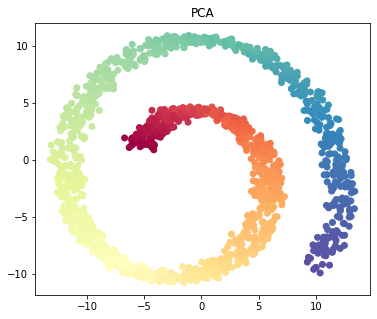

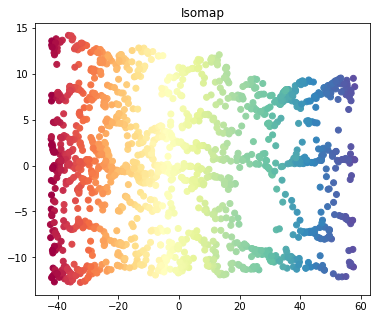

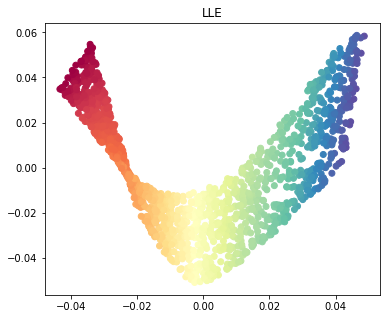

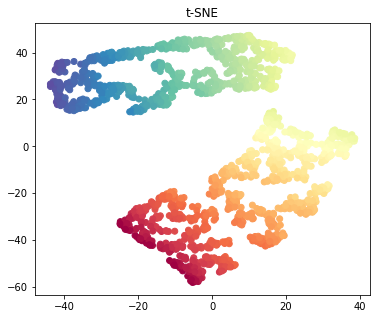

In [14]:
# !pip install umap-learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
# import umap

# Generate Swiss Roll data
X, color = make_swiss_roll(n_samples=1500, noise=0.2)

# Helper function to plot embeddings
def plot_embedding(Y, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.axis('tight')

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_embedding(X_pca, "PCA")

# Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X)
plot_embedding(X_isomap, "Isomap")

# LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=12)
X_lle = lle.fit_transform(X)
plot_embedding(X_lle, "LLE")

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, "t-SNE")

# UMAP
# X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
# plot_embedding(X_umap, "UMAP")

plt.show()